## Python Data fitting with various functions - HW 12
Due Monday Dec 2, 2024



Dowload the data "miniDR17.fits" from the TCU Online Week 14:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

_Use masking to remove any remaining bad values (typically 9999 or -9999 in this file_ , <b>but check!!!! If you are not sure, ask!!!</b>). 

In [9]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [15]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

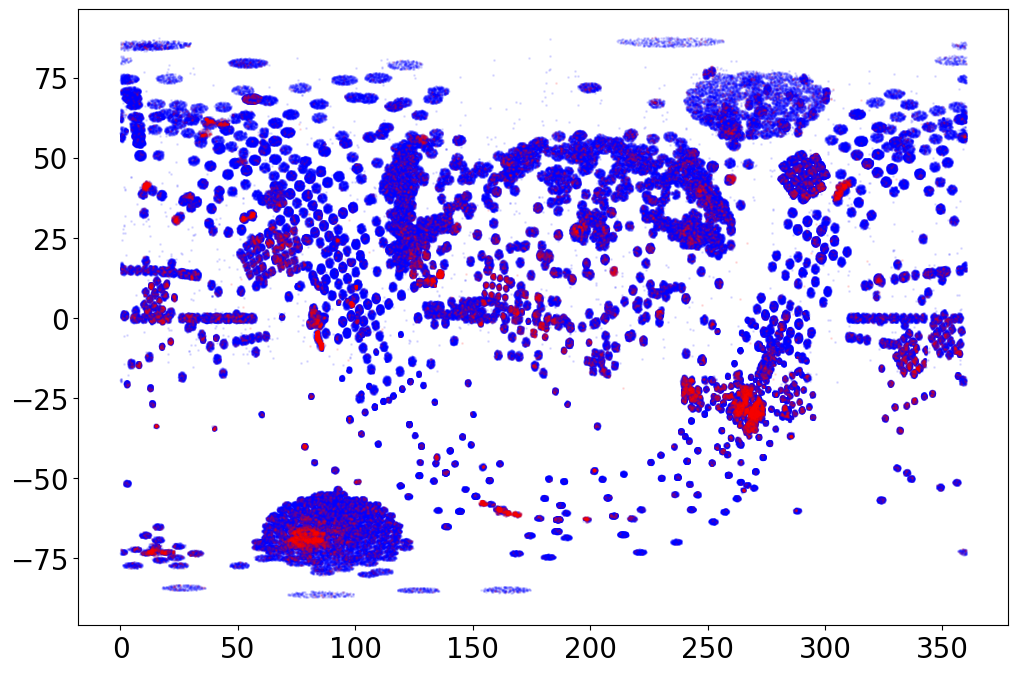

In [4]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)
ax.scatter(star['RA'][bad],star['DEC'][bad],s=1,c='r',alpha=0.1)


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.634
COSFIT: 72.947, 0.018, -0.452, -5.700


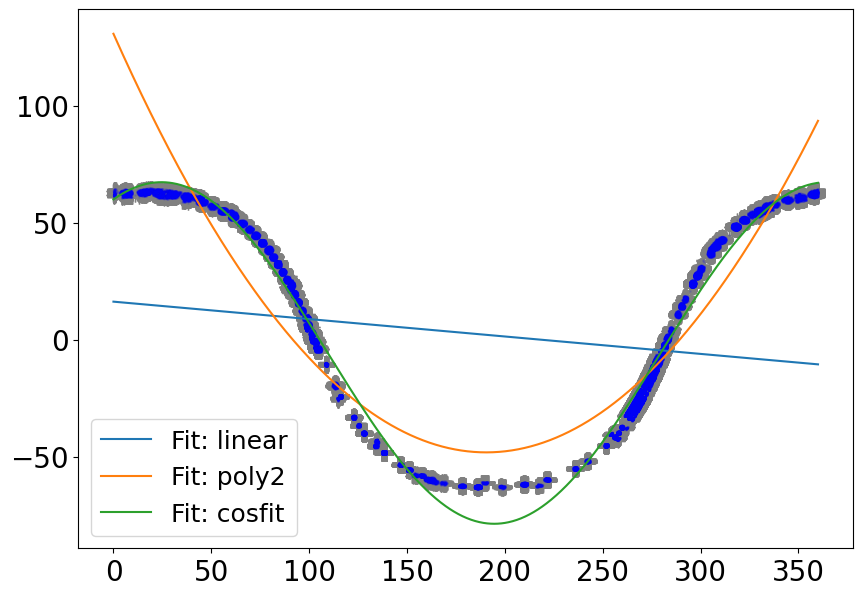

In [11]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 2) &\
     (star['GLAT'] > -2) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                          0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                         0.001,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                            0.001,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['RA'][cut1],star['DEC'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['RA'][cut1]),star['DEC'][cut1], xerr=(0.001),
             yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

# Homework #12

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_24_HW12a.ipynb

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Linear Fit: a = -0.233, b = 0.054
Poly2 Fit: a = -0.074, b = -0.317, c = 0.048
Poly3 Fit: a = 0.075, b = 0.093, c = -0.262, d = 0.045


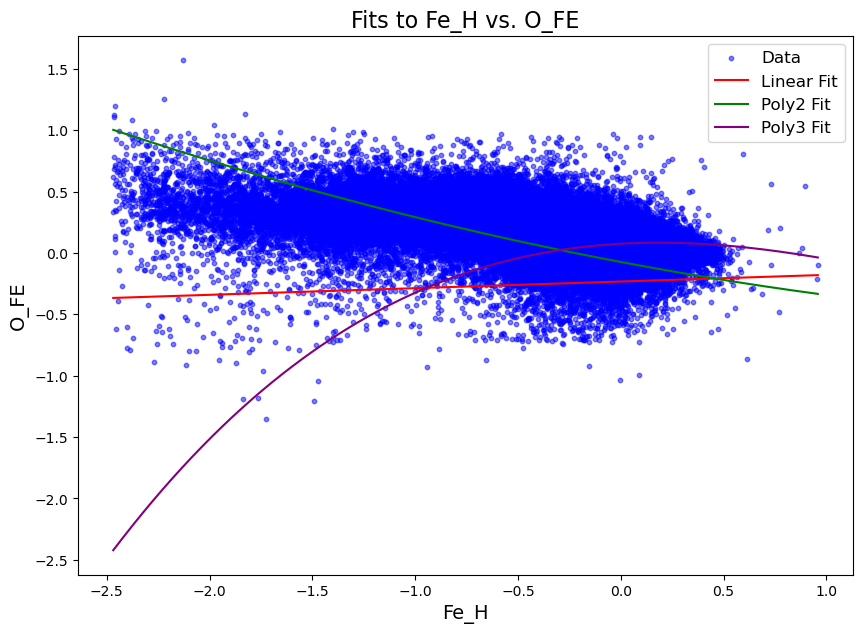

In [125]:
# write your fitting code, from part 1, and plot the results here
import numpy as np
import matplotlib.pyplot as plt

def linear(x, a, b):
    return a * x + b

def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

mask = (np.bitwise_and(star['aspcapflag'], 2**23) == 0) & \
       (np.bitwise_and(star['starflag'], 2**16) == 0) & \
       (star['GLAT'] > 20) & \
       (~np.isnan(star['Fe_H'])) & \
       (~np.isnan(star['O_FE']))

x_data = star['Fe_H'][mask]
y_data = star['O_FE'][mask]

linear_params = np.polyfit(x_data, y_data, 1)  
poly2_params = np.polyfit(x_data, y_data, 2)   
poly3_params = np.polyfit(x_data, y_data, 3)   


print(f'Linear Fit: a = {linear_params[0]:.3f}, b = {linear_params[1]:.3f}')
print(f'Poly2 Fit: a = {poly2_params[0]:.3f}, b = {poly2_params[1]:.3f}, c = {poly2_params[2]:.3f}')
print(f'Poly3 Fit: a = {poly3_params[0]:.3f}, b = {poly3_params[1]:.3f}, c = {poly3_params[2]:.3f}, d = {poly3_params[3]:.3f}')


plt.figure(figsize=(10, 7))
plt.scatter(x_data, y_data, s=10, color='blue', alpha=0.5, label='Data')

x_plot = np.linspace(min(x_data), max(x_data), 500)
plt.plot(x_plot, linear(x_plot, *linear_params[::-1]), label='Linear Fit', color='red')
plt.plot(x_plot, poly2(x_plot, *poly2_params[::-1]), label='Poly2 Fit', color='green')
plt.plot(x_plot, poly3(x_plot, *poly3_params[::-1]), label='Poly3 Fit', color='purple')

plt.xlabel('Fe_H', fontsize=14)
plt.ylabel('O_FE', fontsize=14)
plt.title('Fits to Fe_H vs. O_FE', fontsize=16)
plt.legend(fontsize=12)
plt.show()






## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

Linear Fit: slope = -0.137, intercept = 0.040
Poly2 Fit: a = -0.020, b = -0.146, c = 0.041
Poly3 Fit: a = 0.091, b = 0.131, c = -0.131, d = 0.033


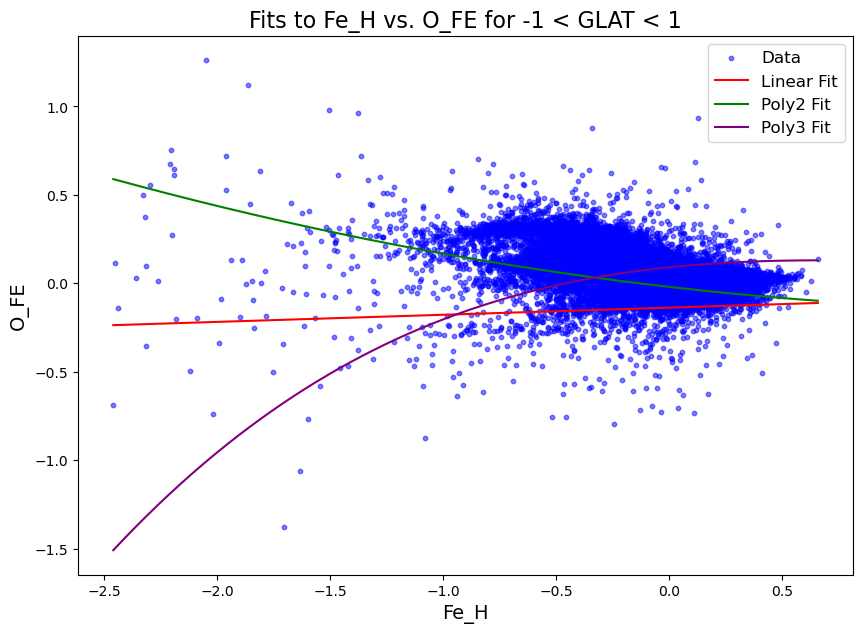

In [127]:
# write your fitting code, from part 1, and plot the results here
import numpy as np
import matplotlib.pyplot as plt

def linear(x, a, b):
    return a * x + b

def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

mask = (np.bitwise_and(star['aspcapflag'], 2**23) == 0) & \
       (np.bitwise_and(star['starflag'], 2**16) == 0) & \
       (-1 < star['GLAT']) & (star['GLAT'] < 1) & \
       (~np.isnan(star['Fe_H'])) & (~np.isnan(star['O_FE']))

x_data = star['Fe_H'][mask]
y_data = star['O_FE'][mask]

linear_params = np.polyfit(x_data, y_data, 1)
poly2_params = np.polyfit(x_data, y_data, 2)
poly3_params = np.polyfit(x_data, y_data, 3)

print(f"Linear Fit: slope = {linear_params[0]:.3f}, intercept = {linear_params[1]:.3f}")
print(f"Poly2 Fit: a = {poly2_params[0]:.3f}, b = {poly2_params[1]:.3f}, c = {poly2_params[2]:.3f}")
print(f"Poly3 Fit: a = {poly3_params[0]:.3f}, b = {poly3_params[1]:.3f}, c = {poly3_params[2]:.3f}, d = {poly3_params[3]:.3f}")

plt.figure(figsize=(10, 7))
plt.scatter(x_data, y_data, s=10, color="blue", alpha=0.5, label="Data")
x_plot = np.linspace(min(x_data), max(x_data), 500)

plt.plot(x_plot, linear(x_plot, *linear_params[::-1]), label="Linear Fit", color="red")
plt.plot(x_plot, poly2(x_plot, *poly2_params[::-1]), label="Poly2 Fit", color="green")
plt.plot(x_plot, poly3(x_plot, *poly3_params[::-1]), label="Poly3 Fit", color="purple")

plt.xlabel("Fe_H", fontsize=14)
plt.ylabel("O_FE", fontsize=14)
plt.title("Fits to Fe_H vs. O_FE for -1 < GLAT < 1", fontsize=16)
plt.legend(fontsize=12)
plt.show()







## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: slope = 0.0, intercept = 0.3
POLY3: A = 0.0, B = -0.0, C = 0.0, D = -4.1
EXPONENTIAL: A = 0.0, B = -4.4, C = 0.0, D = 0.3


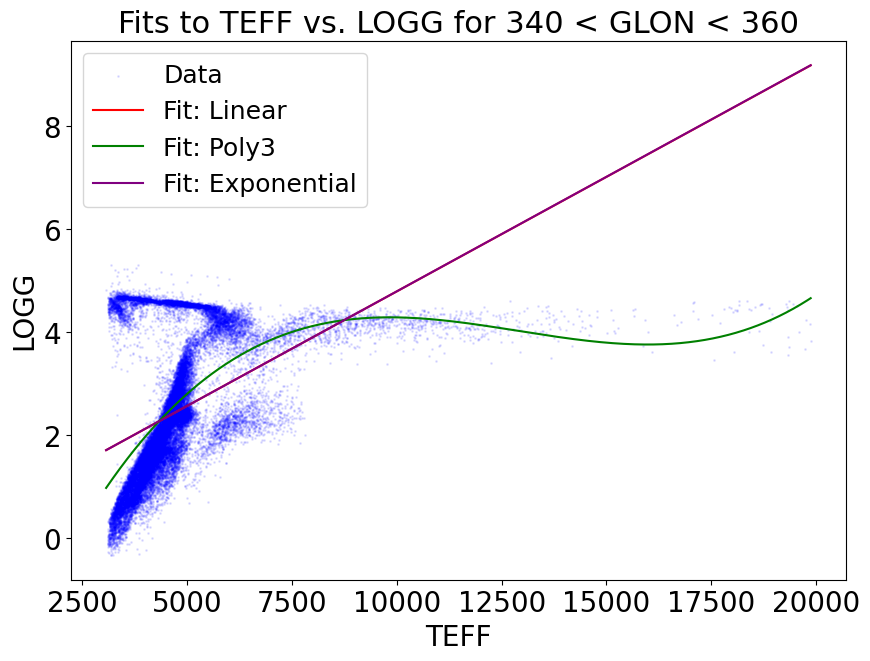

In [135]:
# write your fitting code and plot the results here

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_scaled(x, A, B, C, D):
    x_scaled = np.log(x)
    return A * np.exp(B * x_scaled) + C * x + D

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

badbits = 2**23
suspectbits = 2**16

ct3 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star["GLON"] > 340) & (star["GLON"] < 360) & \
      (~np.isnan(star["TEFF"])) & (~np.isnan(star["LOGG"]))

cut3 = np.where(ct3)

x_data = star['TEFF'][cut3]
y_data = star['LOGG'][cut3]


x_err = np.ones_like(x_data) 
y_err = np.ones_like(y_data) 

slope, intercept = mcFit2(linear, x_data, y_data, x_err, y_err, p0=[0, 0])
print(f'LINEAR: slope = {slope:.1f}, intercept = {intercept:.1f}')

polyA, polyB, polyC, polyD = mcFit4(poly3, x_data, y_data, x_err, y_err, p0=[0, 0, 0, 0])
print(f'POLY3: A = {polyA:.1f}, B = {polyB:.1f}, C = {polyC:.1f}, D = {polyD:.1f}')

bounds = ([0, -10, -10, -10], [10, 10, 10, 10])

popt, pcov = curve_fit(exponential_scaled, x_data, y_data, p0=[1, 0.1, 1, 1], bounds=bounds, maxfev=10000)
expA, expB, expC, expD = popt
print(f'EXPONENTIAL: A = {expA:.1f}, B = {expB:.1f}, C = {expC:.1f}, D = {expD:.1f}')

fig3 = plt.figure(figsize=(10, 7))
ax3 = fig3.add_subplot(111)
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)

ax3.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')

x_plot = np.linspace(np.min(x_data), np.max(x_data), 1000)

ax3.plot(x_plot, linear(x_plot, slope, intercept), label='Fit: Linear', color='r')
ax3.plot(x_plot, poly3(x_plot, polyA, polyB, polyC, polyD), label='Fit: Poly3', color='g')
ax3.plot(x_plot, exponential_scaled(x_plot, expA, expB, expC, expD), label='Fit: Exponential', color='purple')

plt.legend(loc='best', fontsize=18)
plt.xlabel('TEFF', fontsize=20)
plt.ylabel('LOGG', fontsize=20)
plt.title('Fits to TEFF vs. LOGG for 340 < GLON < 360', fontsize=22)
plt.show()



## DATA FIT 4

Fit  a linear, a exponential, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) (JK_ERR)__<br>
<br>
<b>NOTE: you will have to create a (J-K) error:</b>  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

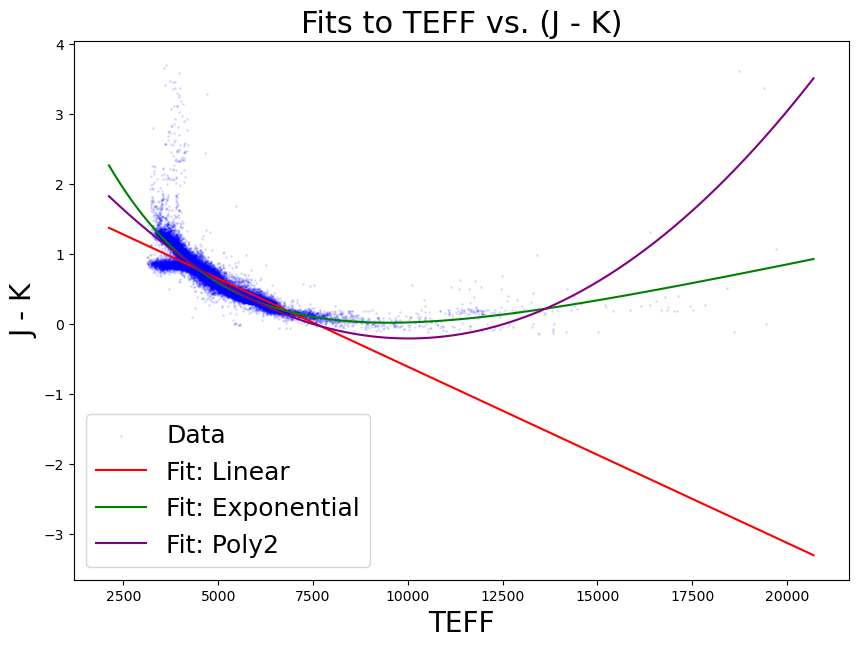

In [137]:
# write your fitting code and plot the results here
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

def poly2(x, A, B, C):
    return A * x**2 + B * x + C

badbits = 2**23
suspectbits = 2**16

ct4 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star["DEC"] < -50) & (star["RA"] > 50) & (star["RA"] < 120) & \
      (~np.isnan(star["TEFF"])) & (~np.isnan(star["J"])) & (~np.isnan(star["K"])) & \
      (~np.isnan(star["J_ERR"])) & (~np.isnan(star["K_ERR"]))

cut4 = np.where(ct4)

x_data = star['TEFF'][cut4]
y_data = star['J'][cut4] - star['K'][cut4]
JK_ERR = np.sqrt(star['J_ERR'][cut4]**2 + star['K_ERR'][cut4]**2)

if len(x_data) > 0:
    params, _ = curve_fit(linear, x_data, y_data, sigma=JK_ERR, p0=[0, 0])
    slope, intercept = params
    exp_guess_A = np.max(y_data) - np.min(y_data)
    exp_guess_B = -0.001
    exp_params, _ = curve_fit(exponential, x_data, y_data, sigma=JK_ERR, p0=[exp_guess_A, exp_guess_B, 0, 0])
    poly_params, _ = curve_fit(poly2, x_data, y_data, sigma=JK_ERR, p0=[0, 0, 0])

    x_min, x_max = min(x_data), max(x_data)
    x_plot = np.linspace(x_min - 1000, x_max + 1000, 20000)

    plt.figure(figsize=(10, 7))
    plt.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')
    plt.plot(x_plot, linear(x_plot, *params), label='Fit: Linear', color='r')
    plt.plot(x_plot, exponential(x_plot, *exp_params), label='Fit: Exponential', color='g')
    plt.plot(x_plot, poly2(x_plot, *poly_params), label='Fit: Poly2', color='purple')
    plt.xlabel('TEFF', fontsize=20)
    plt.ylabel('J - K', fontsize=20)
    plt.title('Fits to TEFF vs. (J - K)', fontsize=22)
    plt.legend(loc='best', fontsize=18)
    plt.show()
else:
    print("No data points after filtering. Please check your filter conditions.")






## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON (0.0001) vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

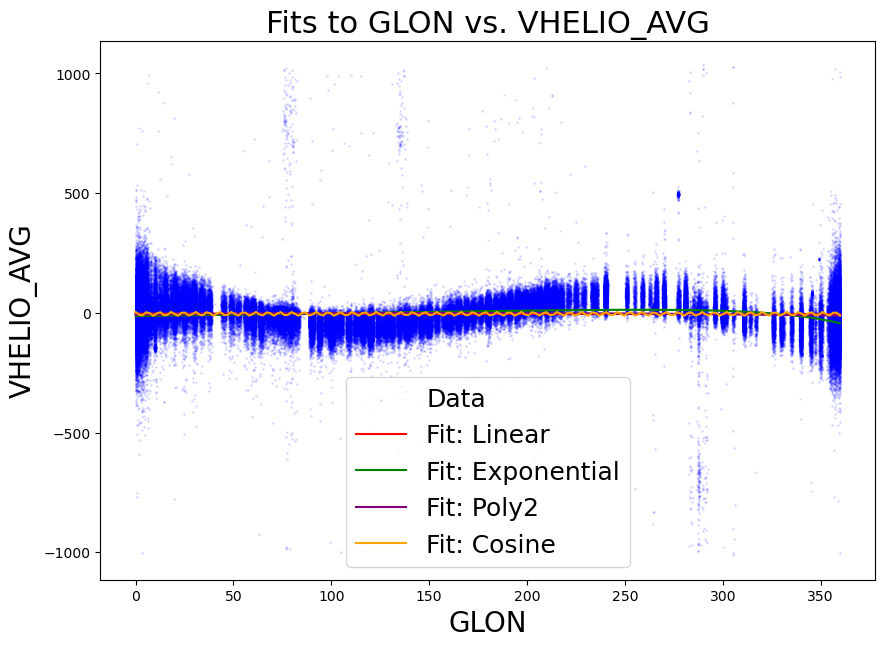

In [143]:
# write your fitting code and plot the results here
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def linear(x, a, b):
    return a * x + b

def exponential(x, A, B, C, D):
    return A * np.exp(B * x) + C * x + D

def poly2(x, A, B, C):
    return A * x**2 + B * x + C

def cosfit(x, A, B, C, D):
    return A * np.cos(B * x + C) + D


ct5 = (star["GLAT"] > -10) & (star["GLAT"] < 10) & \
      (~np.isnan(star["GLON"])) & (~np.isnan(star["VHELIO_AVG"]))
cut5 = np.where(ct5)

x_data = star['GLON'][cut5]
y_data = star['VHELIO_AVG'][cut5]

if len(x_data) > 0:
    ]
    params, _ = curve_fit(linear, x_data, y_data, p0=[0, 0])
    exp_params, _ = curve_fit(exponential, x_data, y_data, p0=[1, 0.1, 1, 1])
    poly2_params, _ = curve_fit(poly2, x_data, y_data, p0=[0, 0, 0])
    cos_params, _ = curve_fit(cosfit, x_data, y_data, p0=[1, 1, 0, 0])

   
    x_plot = np.linspace(min(x_data), max(x_data), 200)
    plt.figure(figsize=(10, 7))
    plt.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')
    plt.plot(x_plot, linear(x_plot, *params), label='Fit: Linear', color='r')
    plt.plot(x_plot, exponential(x_plot, *exp_params), label='Fit: Exponential', color='g')
    plt.plot(x_plot, poly2(x_plot, *poly2_params), label='Fit: Poly2', color='purple')
    plt.plot(x_plot, cosfit(x_plot, *cos_params), label='Fit: Cosine', color='orange')
    plt.xlabel('GLON', fontsize=20)
    plt.ylabel('VHELIO_AVG', fontsize=20)
    plt.title('Fits to GLON vs. VHELIO_AVG', fontsize=22)
    plt.legend(loc='best', fontsize=18)
    plt.show()
else:
    print("No data points after filtering.")





## DATA FIT 6

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

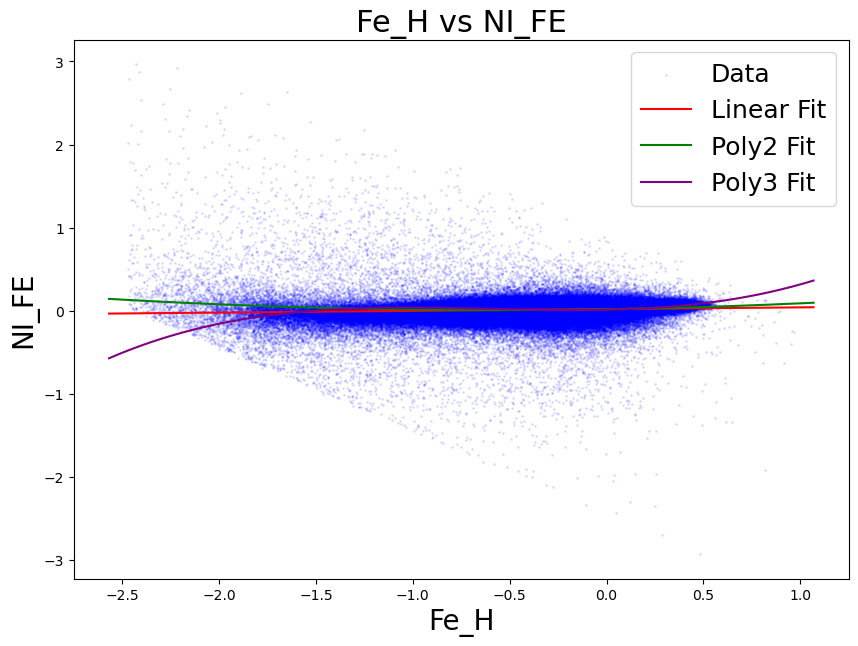

In [147]:
# write your fitting code and plot the results here
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def linear(x, a, b):
    return a * x + b

def poly2(x, A, B, C):
    return A * x**2 + B * x + C

def poly3(x, A, B, C, D):
    return A * x**3 + B * x**2 + C * x + D


ct7 = (np.bitwise_and(star['aspcapflag'], 2**23) == 0) & \
      (np.bitwise_and(star['starflag'], 2**16) == 0) & \
      (~np.isnan(star["Fe_H"])) & (~np.isnan(star["NI_FE"])) & \
      (~np.isnan(star["Fe_H_ERR"])) & (~np.isnan(star["NI_FE_ERR"]))

cut7 = np.where(ct7)

x_data = star['Fe_H'][cut7]
y_data = star['NI_FE'][cut7]
combined_err = np.sqrt(star['Fe_H_ERR'][cut7]**2 + star['NI_FE_ERR'][cut7]**2)


if len(x_data) > 0:
    
    params_linear, _ = curve_fit(linear, x_data, y_data, sigma=combined_err)
    params_poly2, _ = curve_fit(poly2, x_data, y_data, sigma=combined_err)
    params_poly3, _ = curve_fit(poly3, x_data, y_data, sigma=combined_err)

    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(x_data, y_data, s=1, c='b', alpha=0.1, label='Data')

    x_plot = np.linspace(min(x_data) - 0.1, max(x_data) + 0.1, 1000)
    ax.plot(x_plot, linear(x_plot, *params_linear), label='Linear Fit', color='r')
    ax.plot(x_plot, poly2(x_plot, *params_poly2), label='Poly2 Fit', color='g')
    ax.plot(x_plot, poly3(x_plot, *params_poly3), label='Poly3 Fit', color='purple')

    ax.set_xlabel('Fe_H', fontsize=20)
    ax.set_ylabel('NI_FE', fontsize=20)
    ax.set_title('Fe_H vs NI_FE', fontsize=22)
    plt.legend(loc='best', fontsize=18)
    plt.show()
else:
    print("No data points after filtering.")

